# add stream with tuning results

per [APS_Bluesky_tools issue #36](https://github.com/BCDA-APS/APS_BlueSky_tools/issues/36)

## basic setup

In [1]:
from ophyd.scaler import ScalerCH
from ophyd import EpicsMotor
from APS_BlueSky_tools.devices import use_EPICS_scaler_channels, AxisTunerMixin
from bluesky import RunEngine
import bluesky.plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback

%matplotlib notebook
from bluesky.utils import install_nb_kicker
install_nb_kicker()

RE = RunEngine({})
RE.subscribe(BestEffortCallback())

m1 = EpicsMotor("gov:m1", name="m1")
scaler = ScalerCH("gov:scaler1", name="scaler")
scaler.match_names()
use_EPICS_scaler_channels(scaler)
for k, v in scaler.read().items():
    print(k, v)
print("scaler.preset_time", scaler.preset_time.value)

clock {'value': 2000000.0, 'timestamp': 1535668816.917746}
I0 {'value': 0.0, 'timestamp': 1535668816.917746}
scint {'value': 1.0, 'timestamp': 1535668816.917746}
scaler_time {'value': 0.2, 'timestamp': 1535668816.917746}
scaler.preset_time 0.05


In [2]:
RE(bp.count([scaler]))

Transient Scan ID: 1     Time: 2018/08/30 17:40:55
Persistent Unique Scan ID: 'fd9aa2c9-792c-4ec9-a388-09345800c07d'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |      clock |         I0 |      scint |
+-----------+------------+------------+------------+------------+
|         1 | 17:40:56.3 |    2000000 |          1 |          0 |
+-----------+------------+------------+------------+------------+
generator count ['fd9aa2c9'] (scan num: 1)





('fd9aa2c9-792c-4ec9-a388-09345800c07d',)

Transient Scan ID: 2     Time: 2018/08/30 17:40:56
Persistent Unique Scan ID: '12902a0e-1654-4747-a7b5-9e486380523b'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |         m1 |      clock |         I0 |      scint |
+-----------+------------+------------+------------+------------+------------+
|         1 | 17:40:57.4 |   -1.00000 |    2000000 |          0 |          0 |
|         2 | 17:40:57.9 |   -0.50000 |    2000000 |          1 |          1 |
|         3 | 17:40:58.5 |    0.00000 |    2000000 |          1 |          1 |
|         4 | 17:40:59.0 |    0.50000 |    1000000 |          0 |          0 |
|         5 | 17:40:59.6 |    1.00000 |    1000000 |          0 |          0 |
+-----------+------------+------------+------------+------------+------------+
generator scan ['12902a0e'] (scan num: 2)





('12902a0e-1654-4747-a7b5-9e486380523b',)

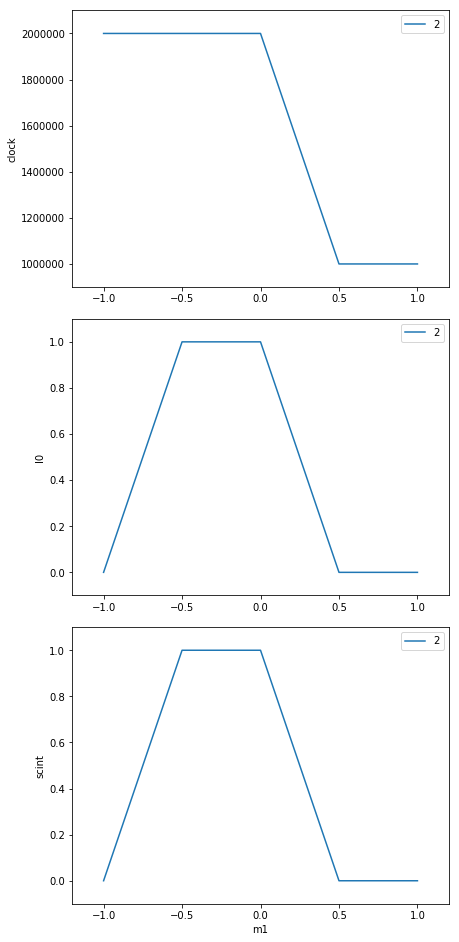

In [3]:
RE(bp.scan([scaler], m1, -1, 1, 5))

## construct the TunableEpicsMotor

In [4]:
from APS_BlueSky_tools.devices import AxisTunerMixin
from APS_BlueSky_tools.plans import TuneAxis

from ophyd import Device, Component, Signal
from collections import OrderedDict, defaultdict
import datetime
import time
from bluesky.callbacks.fitting import PeakStats
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps
from bluesky import plan_patterns as bpat
from bluesky.utils import short_uid as _short_uid
from bluesky.utils import merge_cycler

from bluesky.utils import ts_msg_hook
RE.msg_hook = ts_msg_hook


class TunableEpicsMotor(EpicsMotor, AxisTunerMixin):
    pass


class MyTuneAxis(TuneAxis):
    
    # override the default tune() method

    def tune(self, width=None, num=None, md=None):
        """
        BlueSky plan to execute one pass through the current scan range
        
        Scan self.axis centered about current position from
        ``-width/2`` to ``+width/2`` with ``num`` observations.
        If a peak was detected (default check is that max >= 4*min), 
        then set ``self.tune_ok = True``.

        PARAMETERS
    
        width : float
            width of the tuning scan in the units of ``self.axis``
            Default value in ``self.width`` (initially 1)
        num : int
            number of steps
            Default value in ``self.num`` (initially 10)
        md : dict, optional
            metadata
        """
        width = width or self.width
        num = num or self.num
        
        if self.peak_choice not in self._peak_choices_:
            msg = "peak_choice must be one of {}, geave {}"
            msg = msg.format(self._peak_choices_, self.peak_choice)
            raise ValueError(msg)

        initial_position = self.axis.position
        start = initial_position - width/2
        finish = initial_position + width/2
        self.tune_ok = False

        tune_md = dict(
            width = width,
            initial_position = self.axis.position,
            time_iso8601 = str(datetime.datetime.now()),
            )
        _md = {'tune_md': tune_md,
               'plan_name': self.__class__.__name__ + '.tune',
               'tune_parameters': dict(
                    num = num,
                    width = width,
                    initial_position = self.axis.position,
                    peak_choice = self.peak_choice,
                    x_axis = self.axis.name,
                    y_axis = self.signal_name,
                   )
               }
        _md.update(md or {})
        if "pass_max" not in _md:
            self.stats = []
        self.peaks = PeakStats(x=self.axis.name, y=self.signal_name)
        
        def tune_scan(detectors, axis, start, finish, num, _md):
            """run the tune scan"""
            cycler = bpat.inner_product(num, (axis, start, finish))
            
            signal_list = list(detectors)
            signal_list += [axis,]

            def inner_scan_nd():
                for step in list(cycler):
                    pos = list(step.values())[0]    # TODO: simplify?
                    yield from bps.mv(axis, pos)
                    yield from bps.trigger_and_read(signal_list)

            return (yield from inner_scan_nd())
            
        class Results(Device):
            """because bps.read() needs a Device or a Signal)"""
            x = Component(Signal, name="x")
            y = Component(Signal, name="y")
            cen = Component(Signal, name="cen")
            com = Component(Signal, name="com")
            fwhm = Component(Signal, name="fwhm")
            min = Component(Signal, name="min")
            max = Component(Signal, name="max")
            crossings = Component(Signal, name="crossings")
            read_attrs = "x y cen com fwhm min max crossings".split()

        def add_results_stream(stream_name="tune_PeakStats"):
            """add a stream with the tuning results (from PeakStats)"""
            tune_PeakStats = Results(
                name="tune_PeakStats",
                read_attrs=Results.read_attrs,
                )
            tune_PeakStats.hints["fields"] = ["tune_PeakStats",]
            for key in tune_PeakStats.read_attrs:
                getattr(tune_PeakStats, key).put(getattr(self.peaks, key))
            yield from bps.create(name=stream_name)
            yield from bps.read(tune_PeakStats)
            yield from bps.save()
        
        @bpp.subs_decorator(self.peaks)
        def _scan():
            yield from bps.open_run()
            yield from tune_scan(
                self.signals, self.axis, start, finish, num, _md)
            
            final_position = initial_position
            if self.peak_detected():
                self.tune_ok = True
                if self.peak_choice == "cen":
                    final_position = self.peaks.cen
                elif self.peak_choice == "com":
                    final_position = self.peaks.com
                else:
                    final_position = None
                self.center = final_position

            # add stream with results
            yield from add_results_stream()
            
            yield from bps.mv(self.axis, final_position)
            self.stats.append(self.peaks)
            yield from bps.close_run()
    
        return (yield from _scan())


m1 = TunableEpicsMotor("gov:m1", name="m1")
m1.tuner = MyTuneAxis([scaler], m1, signal_name="scint")
m1.tuner.width = 0.02
m1.tuner.num = 21


m1 position before tuning: 1.0
17:41:00.331029 subscribe         -> None            args: (<bluesky.callbacks.fitting.PeakStats object at 0x7f3b4a7e8d30>, 'all'), kwargs: {}
17:41:00.332083 open_run          -> None            args: (), kwargs: {}
Transient Scan ID: 3     Time: 2018/08/30 17:41:00
Persistent Unique Scan ID: '3cdca8ac-6bf7-4b64-bb0d-b455341662cc'
start {'uid': '3cdca8ac-6bf7-4b64-bb0d-b455341662cc', 'time': 1535668860.3324108, 'plan_type': 'generator', 'scan_id': 3, 'plan_name': 'tune'}
17:41:00.335029 set               -> m1              args: (0.98999999999999999,), kwargs: {'group': '151ed6cf-02de-4c0d-894a-44e11f8d7f9f'}
17:41:00.336434 wait              -> None            args: (), kwargs: {'group': '151ed6cf-02de-4c0d-894a-44e11f8d7f9f'}
17:41:00.372618 trigger           -> scaler          args: (), kwargs: {'group': 'trigger-995a73'}
17:41:00.373153 trigger           -> m1              args: (), kwargs: {'group': 'trigger-995a73'}
17:41:00.373414 wait            

event {'descriptor': 'def32c4b-770c-4b63-908e-1493a00a1614', 'time': 1535668861.1226914, 'data': {'clock': 1000000.0, 'I0': 0.0, 'scint': 0.0, 'scaler_time': 0.1, 'm1': 0.99, 'm1_user_setpoint': 0.99}, 'timestamps': {'clock': 1535668860.658528, 'I0': 1535668860.658528, 'scint': 1535668860.658528, 'scaler_time': 1535668860.658528, 'm1': 1535668860.370504, 'm1_user_setpoint': 1535668860.370504}, 'seq_num': 1, 'uid': '99f6765e-5b38-4077-8e67-6bddfc7c197f', 'filled': {}}
17:41:01.362470 set               -> m1              args: (0.99099999999999999,), kwargs: {'group': '12aeb993-ff92-4963-b11f-b4bbbae8f926'}
17:41:01.364319 wait              -> None            args: (), kwargs: {'group': '12aeb993-ff92-4963-b11f-b4bbbae8f926'}
17:41:01.373702 trigger           -> scaler          args: (), kwargs: {'group': 'trigger-c42a69'}
17:41:01.374262 trigger           -> m1              args: (), kwargs: {'group': 'trigger-c42a69'}
17:41:01.374571 wait              -> None            args: (), kwarg

event {'descriptor': 'def32c4b-770c-4b63-908e-1493a00a1614', 'time': 1535668864.5695925, 'data': {'clock': 2000000.0, 'I0': 1.0, 'scint': 0.0, 'scaler_time': 0.2, 'm1': 0.996, 'm1_user_setpoint': 0.996}, 'timestamps': {'clock': 1535668864.562505, 'I0': 1535668864.562505, 'scint': 1535668864.562505, 'scaler_time': 1535668864.562505, 'm1': 1535668864.274578, 'm1_user_setpoint': 1535668864.274578}, 'seq_num': 7, 'uid': '00231c6f-99fd-4f53-8d7b-1172cb9c9e55', 'filled': {}}
17:41:04.847314 set               -> m1              args: (0.997,), kwargs: {'group': '205df348-fc70-42a5-b78e-404f55c858bb'}
17:41:04.848927 wait              -> None            args: (), kwargs: {'group': '205df348-fc70-42a5-b78e-404f55c858bb'}
17:41:04.878788 trigger           -> scaler          args: (), kwargs: {'group': 'trigger-36b76d'}
17:41:04.879595 trigger           -> m1              args: (), kwargs: {'group': 'trigger-36b76d'}
17:41:04.880138 wait              -> None            args: (), kwargs: {'group':

event {'descriptor': 'def32c4b-770c-4b63-908e-1493a00a1614', 'time': 1535668868.0738223, 'data': {'clock': 2000000.0, 'I0': 0.0, 'scint': 0.0, 'scaler_time': 0.2, 'm1': 1.002, 'm1_user_setpoint': 1.002}, 'timestamps': {'clock': 1535668868.066824, 'I0': 1535668868.066824, 'scint': 1535668868.066824, 'scaler_time': 1535668868.066824, 'm1': 1535668867.778011, 'm1_user_setpoint': 1535668867.778011}, 'seq_num': 13, 'uid': 'ee2064d7-a7eb-4dc6-add6-6e8029c9f08e', 'filled': {}}
17:41:08.351347 set               -> m1              args: (1.0030000000000001,), kwargs: {'group': '213e1940-6ce1-4a68-8fd2-89f94ef22f6a'}
17:41:08.352737 wait              -> None            args: (), kwargs: {'group': '213e1940-6ce1-4a68-8fd2-89f94ef22f6a'}
17:41:08.380582 trigger           -> scaler          args: (), kwargs: {'group': 'trigger-12bce0'}
17:41:08.381139 trigger           -> m1              args: (), kwargs: {'group': 'trigger-12bce0'}
17:41:08.381428 wait              -> None            args: (), kwa

event {'descriptor': 'def32c4b-770c-4b63-908e-1493a00a1614', 'time': 1535668871.6761546, 'data': {'clock': 2000000.0, 'I0': 1.0, 'scint': 0.0, 'scaler_time': 0.2, 'm1': 1.008, 'm1_user_setpoint': 1.008}, 'timestamps': {'clock': 1535668871.669831, 'I0': 1535668871.669831, 'scint': 1535668871.669831, 'scaler_time': 1535668871.669831, 'm1': 1535668871.382065, 'm1_user_setpoint': 1535668871.382065}, 'seq_num': 19, 'uid': 'f70e3f33-5169-437f-b6f2-f440d965d4d6', 'filled': {}}
17:41:11.945503 set               -> m1              args: (1.0089999999999999,), kwargs: {'group': 'd1c0a26d-c2d5-47d7-b9ac-1b92ec65df55'}
17:41:11.946846 wait              -> None            args: (), kwargs: {'group': 'd1c0a26d-c2d5-47d7-b9ac-1b92ec65df55'}
17:41:11.984554 trigger           -> scaler          args: (), kwargs: {'group': 'trigger-c69709'}
17:41:11.984988 trigger           -> m1              args: (), kwargs: {'group': 'trigger-c69709'}
17:41:11.985280 wait              -> None            args: (), kwa

('3cdca8ac-6bf7-4b64-bb0d-b455341662cc',)

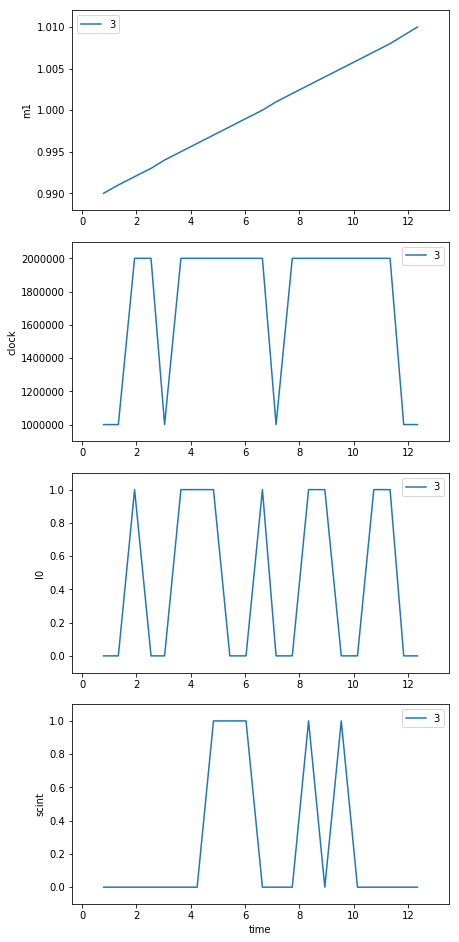

In [5]:
RE(m1.tune(), print)